# Evaluation script

## Load packages

In [32]:
Sys.setenv("PKG_CXXFLAGS"="-std=c++14")

# List of required packages
list_of_packages <- c("here", "dplyr", "ggplot2", "reshape2")

# Function to load packages and handle errors
load_if_installed <- function(p) {
  tryCatch({
    library(p, character.only = TRUE)
  }, error = function(e) {
    message(sprintf("Package '%s' is not installed.", p))
  })
}

# Load all required packages
lapply(list_of_packages, load_if_installed)

[[1]]
[1] "dplyr"     "here"      "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[2]]
[1] "dplyr"     "here"      "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "ggplot2"   "dplyr"     "here"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "reshape2"  "ggplot2"   "dplyr"     "here"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

## Load results

In [2]:
datanames <- c("cps", "adult")
modelnames <- c("orig", "cart", "rf", "bn", "xgb", "svm")

loaded_data <- list()

# Loop through all combinations of dataname and modelname
for (dataname in datanames) {
  for (modelname in modelnames) {
    # Construct the file path
    file_path <- paste0(here(), "/results/", dataname, "_", modelname, "_res.RData")
    
    # Check if the file exists
    if (file.exists(file_path)) {
      # Load the file if it exists
      load(file = file_path)
      
      # Assign the loaded data to the list
      loaded_data[[paste0(dataname, "_", modelname)]] <- get(ls()[1])
      
      cat("Loaded data for:", dataname, modelname, "\n")
    } else {
      # Print message if the file does not exist
      cat("Data does not exist for:", dataname, modelname, "\n")
    }
  }
}

# Print all loaded dataframes
cat("\n--- List of loaded dataframes ---\n")
for (name in names(loaded_data)) {
  cat("Data for:", name, "\n")
  print(loaded_data[[name]])
}

Loaded data for: cps orig 
Loaded data for: cps cart 
Data does not exist for: cps rf 
Loaded data for: cps bn 
Loaded data for: cps xgb 
Data does not exist for: cps svm 
Loaded data for: adult orig 
Loaded data for: adult cart 
Data does not exist for: adult rf 
Loaded data for: adult bn 
Loaded data for: adult xgb 
Data does not exist for: adult svm 

--- List of loaded dataframes ---
Data for: cps_orig 
$eval_regression_avg
          MAE        MSE     RMSE R_squared     MAPE
CART 27081.35 1728972408 41580.91 0.2699372 5346.312
RF   25191.51 1611471960 40143.12 0.3343683 4432.881
XGB  24894.57 1588800820 39859.04 0.3437388 4358.569
SVM  25695.09 1847248426 42977.06 0.2371105 3634.983

$eval_bn_avg
   Accuracy        F1 Sensitivity Specificity
1 0.9603824 0.9797909         0.2         0.8

Data for: cps_cart 
$eval_regression_avg
          MAE        MSE     RMSE R_squared     MAPE
CART 27243.17 1843154279 42931.97 0.2630100 3661.599
RF   25103.50 1607652084 40089.80 0.3436767 3891.

## Metric Tables

In [25]:
# Define the datasets and models
datanames <- c("cps", "adult")
modelnames <- c("orig", "cart", "rf", "xgb", "svm")
metrics_regression <- c("MAE", "MSE", "RMSE", "R_squared", "MAPE") # For cps
metrics_classification <- c("Accuracy", "F1", "Sensitivity", "Specificity") # For adult

# Initialize empty data frames for cps and adult datasets
cps_table <- data.frame(matrix(ncol = length(modelnames) + 2, nrow = 0))  # +2 for model and metric columns
colnames(cps_table) <- c("Prediction Model", "Metric", "Original Data", "CART-syn. Data", "RF-syn. Data", "XGB-syn. Data", "SVM-syn. Data")

adult_table <- data.frame(matrix(ncol = length(modelnames) + 2, nrow = 0))  # +2 for model and metric columns
colnames(adult_table) <- c("Prediction Model", "Metric", "Original Data", "CART-syn. Data", "RF-syn. Data", "XGB-syn. Data", "SVM-syn. Data")

# Fill in the cps table with regression metrics
for (model in c("CART", "RF", "XGB", "SVM")) {
  for (metric in metrics_regression) {
    row <- c(model, metric)
    for (modelname in modelnames) {
      df_name <- paste0("cps_", modelname)
      if (!is.null(loaded_data[[df_name]])) {
        regression_metrics <- loaded_data[[df_name]]$eval_regression_avg
        if (!is.null(regression_metrics) && !is.null(regression_metrics[model, metric])) {
          row <- c(row, regression_metrics[model, metric])
        } else {
          row <- c(row, NA)
        }
      } else {
        row <- c(row, NA)
      }
    }
    cps_table <- rbind(cps_table, row)
  }
}

# Fill in the adult table with classification metrics
for (model in c("CART", "RF", "XGB", "SVM", "BN")) {
  for (metric in metrics_classification) {
    row <- c(model, metric)
    for (modelname in modelnames) {
      df_name <- paste0("adult_", modelname)
      if (!is.null(loaded_data[[df_name]])) {
        classification_metrics <- loaded_data[[df_name]]$eval_classification_avg
        if (!is.null(classification_metrics) && !is.null(classification_metrics[model, metric])) {
          row <- c(row, classification_metrics[model, metric])
        } else {
          row <- c(row, NA)
        }
      } else {
        row <- c(row, NA)
      }
    }
    adult_table <- rbind(adult_table, row)
  }
}

# Print the tables with correct column names
cat("\n--- CPS Dataset Table (Regression) ---\n")
colnames(cps_table) <- c("Prediction Model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data")
print(cps_table)

cat("\n--- Adult Dataset Table (Classification) ---\n")
colnames(adult_table) <- c("Prediction Model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data")
print(adult_table)



--- CPS Dataset Table (Regression) ---
   Prediction Model    Metric     Original data    CART-syn. data RF-syn. data
1              CART       MAE  27081.3492082474  27243.1708662494         <NA>
2              CART       MSE  1728972407.68385  1843154279.18516         <NA>
3              CART      RMSE   41580.913983267   42931.972691517         <NA>
4              CART R_squared 0.269937192505549  0.26301003814581         <NA>
5              CART      MAPE  5346.31238234134  3661.59947812589         <NA>
6                RF       MAE  25191.5051777678  25103.4957043833         <NA>
7                RF       MSE  1611471960.02314  1607652084.39266         <NA>
8                RF      RMSE  40143.1249759819  40089.8028473072         <NA>
9                RF R_squared 0.334368338482898 0.343676749291347         <NA>
10               RF      MAPE  4432.88050663417  3891.64392602762         <NA>
11              XGB       MAE  24894.5711479295  25009.2344040663         <NA>
12          

### Extra BN Tables for CPS data

#### BN Prediction Model Metrics on Different Synthetic Models' Data

In [26]:
# initialize dataframe
bn_cps_table <- data.frame(matrix(ncol = length(modelnames) + 3, nrow = 0))  # +3 for model, metric columns and BN column

model <- "BN"
for (metric in metrics_classification) {  # Use classification metrics for the cps data
  row <- c(model, metric)
  for (modelname in modelnames) {
    df_name <- paste0("cps_", modelname)
    if (!is.null(loaded_data[[df_name]])) {
      classification_metrics <- loaded_data[[df_name]]$eval_classification_avg
      if (!is.null(classification_metrics) && !is.null(classification_metrics[model, metric])) {
        row <- c(row, classification_metrics[model, metric])
      } else {
        row <- c(row, NA)
      }
    } else {
      row <- c(row, NA)
    }
  }
  
  # Add metrics for BN-syn. data
  df_name_bn <- "cps_bn"
  if (!is.null(loaded_data[[df_name_bn]])) {
    classification_metrics_bn <- loaded_data[[df_name_bn]]$eval_classification_avg
    if (!is.null(classification_metrics_bn) && !is.null(classification_metrics_bn[model, metric])) {
      row <- c(row, classification_metrics_bn[model, metric])
    } else {
      row <- c(row, NA)
    }
  } else {
    row <- c(row, NA)
  }
  
  bn_cps_table <- rbind(bn_cps_table, row)
}

# Assign the column names right before printing
colnames(bn_cps_table) <- c("Prediction model", "Metric", "Original data", "CART-syn. data", "RF-syn. data", "XGB-syn. data", "SVM/R-syn. data", "BN-syn. data")

# Print the BN prediction model table with the BN-syn. column
cat("\n--- BN Prediction Model on Different Synthetic data (CPS Dataset) ---\n")
print(bn_cps_table)



--- BN Prediction Model on Different Synthetic data (CPS Dataset) ---


  Prediction model      Metric Original data CART-syn. data RF-syn. data
1               BN    Accuracy          <NA>           <NA>         <NA>
2               BN          F1          <NA>           <NA>         <NA>
3               BN Sensitivity          <NA>           <NA>         <NA>
4               BN Specificity          <NA>           <NA>         <NA>
  XGB-syn. data SVM/R-syn. data BN-syn. data
1          <NA>            <NA>         <NA>
2          <NA>            <NA>         <NA>
3          <NA>            <NA>         <NA>
4          <NA>            <NA>         <NA>


In [27]:
bn_cps_table

Prediction model,Metric,Original data,CART-syn. data,RF-syn. data,XGB-syn. data,SVM/R-syn. data,BN-syn. data
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BN,Accuracy,NA,NA,NA,NA,NA,NA
BN,F1,NA,NA,NA,NA,NA,NA
BN,Sensitivity,NA,NA,NA,NA,NA,NA
BN,Specificity,NA,NA,NA,NA,NA,NA


#### Different Models' Predictions on Synthetic Data Created with BN

In [24]:
# Define the classification metrics for cps dataset (since BN-generated data is discretized)
metrics_classification <- c("Accuracy", "F1", "Sensitivity", "Specificity")

# Initialize an empty data frame for different models' predictions on BN-generated data
bn_synth_cps_table <- data.frame(matrix(ncol = 3, nrow = 0))  # +2 for model and metric columns

# Fill in the table with different models' predictions on BN-synthetic data
for (model in c("CART", "RF", "XGB", "SVM")) {
  for (metric in metrics_classification) {
    row <- c(model, metric)
    df_name <- "cps_bn"  # This is the synthetic data generated by BN
    if (!is.null(loaded_data[[df_name]])) {
      classification_metrics <- loaded_data[[df_name]]$eval_classification_avg
      if (!is.null(classification_metrics) && !is.null(classification_metrics[model, metric])) {
        row <- c(row, classification_metrics[model, metric])
      } else {
        row <- c(row, NA)
      }
    } else {
      row <- c(row, NA)
    }
    bn_synth_cps_table <- rbind(bn_synth_cps_table, row)
  }
}

# Assign the column names right before printing
colnames(bn_synth_cps_table) <- c("Prediction model", "Metric", "BN-syn. data")

# Print the table for different models' predictions on BN-generated data
cat("\n--- Different Models' Predictions on BN-Synthetic data (CPS Dataset) ---\n")
print(bn_synth_cps_table)



--- Different Models' Predictions on BN-Synthetic data (CPS Dataset) ---
   Prediction model      Metric BN-syn. data
1              CART    Accuracy         <NA>
2              CART          F1         <NA>
3              CART Sensitivity         <NA>
4              CART Specificity         <NA>
5                RF    Accuracy         <NA>
6                RF          F1         <NA>
7                RF Sensitivity         <NA>
8                RF Specificity         <NA>
9               XGB    Accuracy         <NA>
10              XGB          F1         <NA>
11              XGB Sensitivity         <NA>
12              XGB Specificity         <NA>
13              SVM    Accuracy         <NA>
14              SVM          F1         <NA>
15              SVM Sensitivity         <NA>
16              SVM Specificity         <NA>


In [28]:
bn_synth_cps_table

Prediction model,Metric,BN-syn. data
<chr>,<chr>,<chr>
CART,Accuracy,NA
CART,F1,NA
CART,Sensitivity,NA
CART,Specificity,NA
RF,Accuracy,NA
RF,F1,NA
RF,Sensitivity,NA
RF,Specificity,NA
XGB,Accuracy,NA


## Heatmaps for metrics

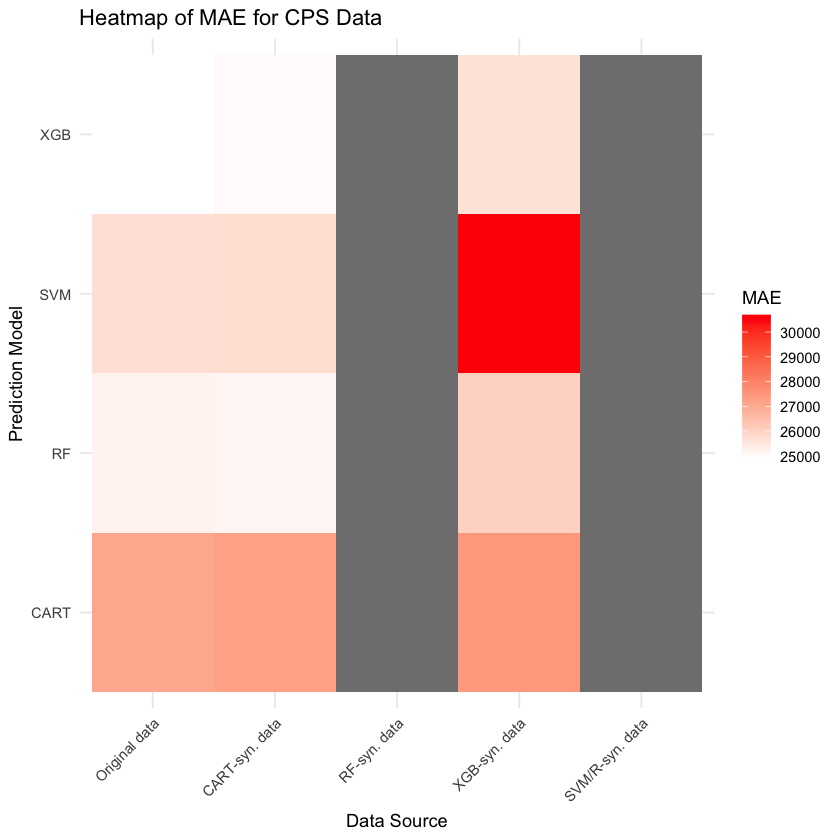

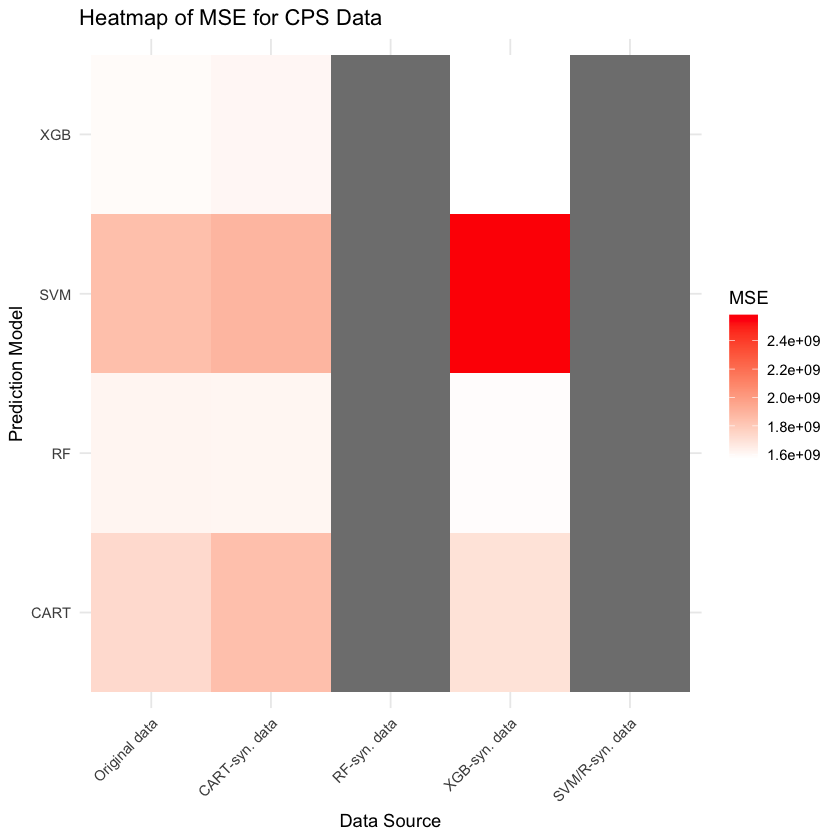

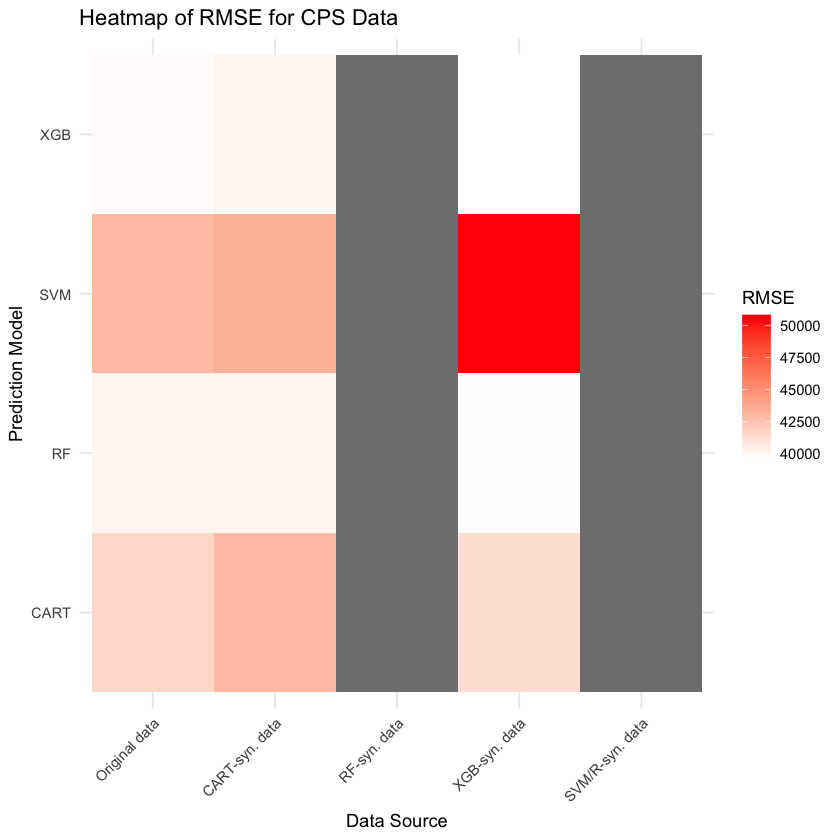

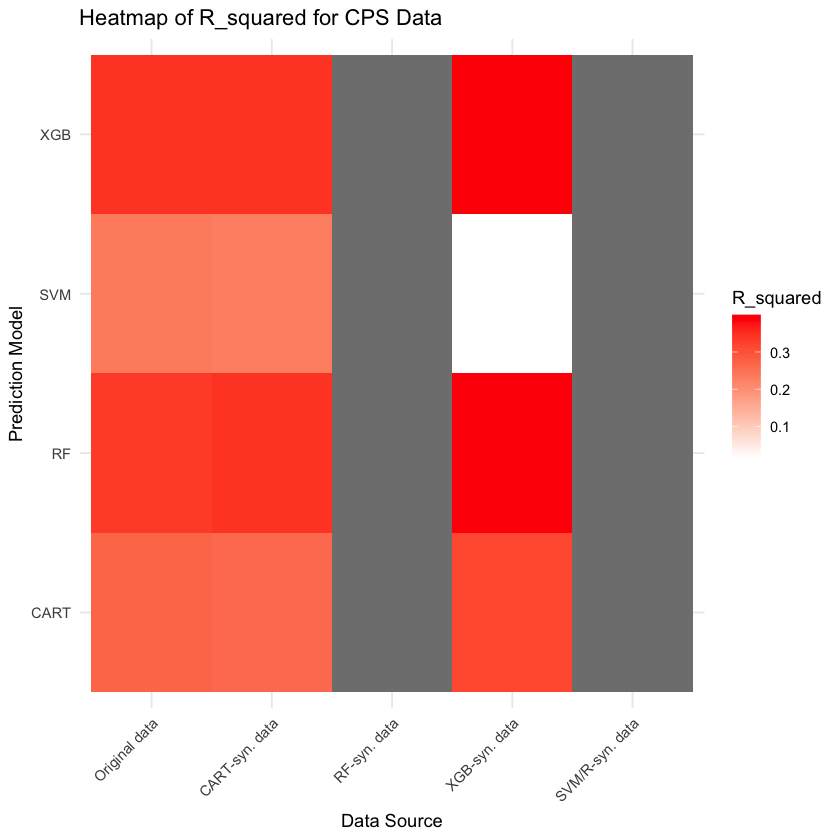

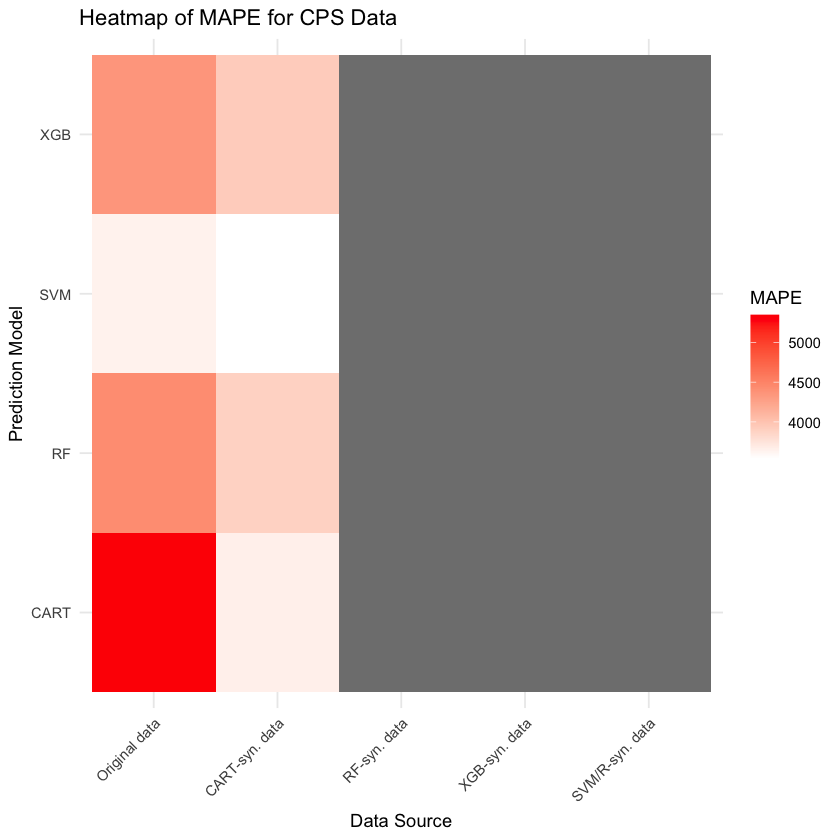

In [37]:
# CPS Data for heatmaps
cps_heatmap_data <- cps_table

# Iterate over each metric in the cps data
for (metric in metrics_regression) {
  # Filter the table for the current metric
  metric_data <- cps_heatmap_data[cps_heatmap_data$Metric == metric, ]
  
  # Melt the data into long format for ggplot
  metric_data_melt <- melt(metric_data, id.vars = c("Prediction Model", "Metric"))
  
  # Create the heatmap
  p <- ggplot(metric_data_melt, aes(x = variable, y = `Prediction Model`, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "red", name = metric) +  # Set the name to the metric
    labs(title = paste("Heatmap of", metric, "for CPS Data"), x = "Data Source", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}


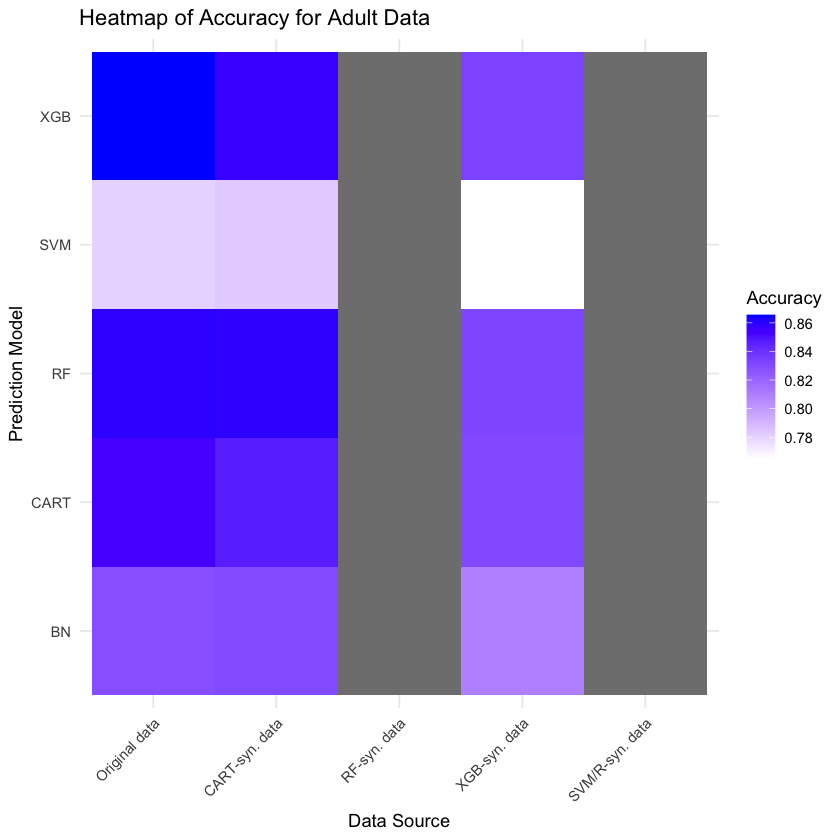

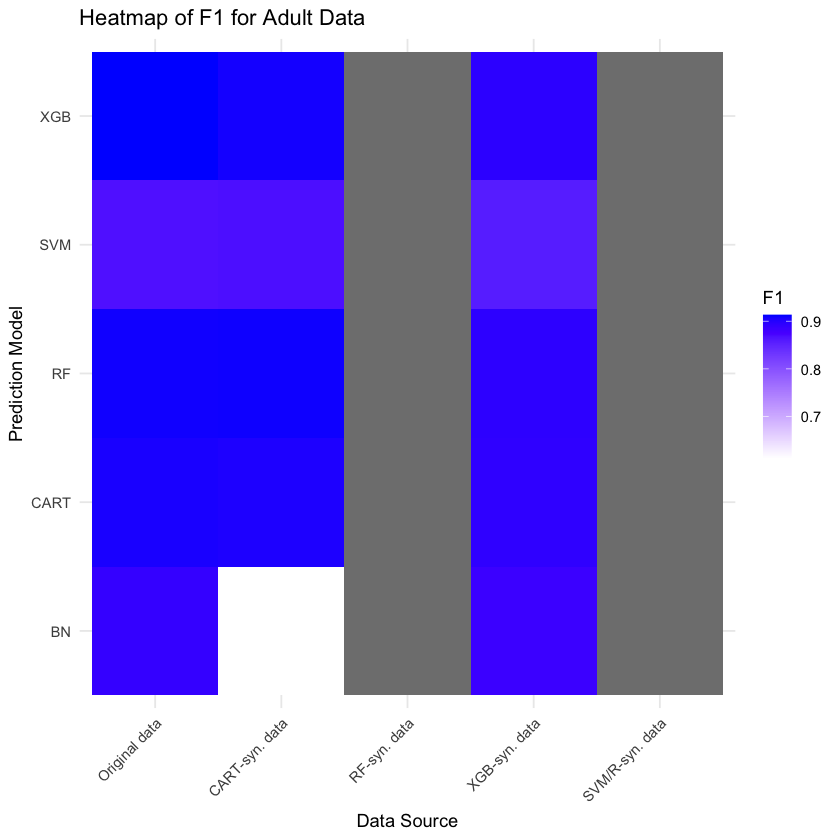

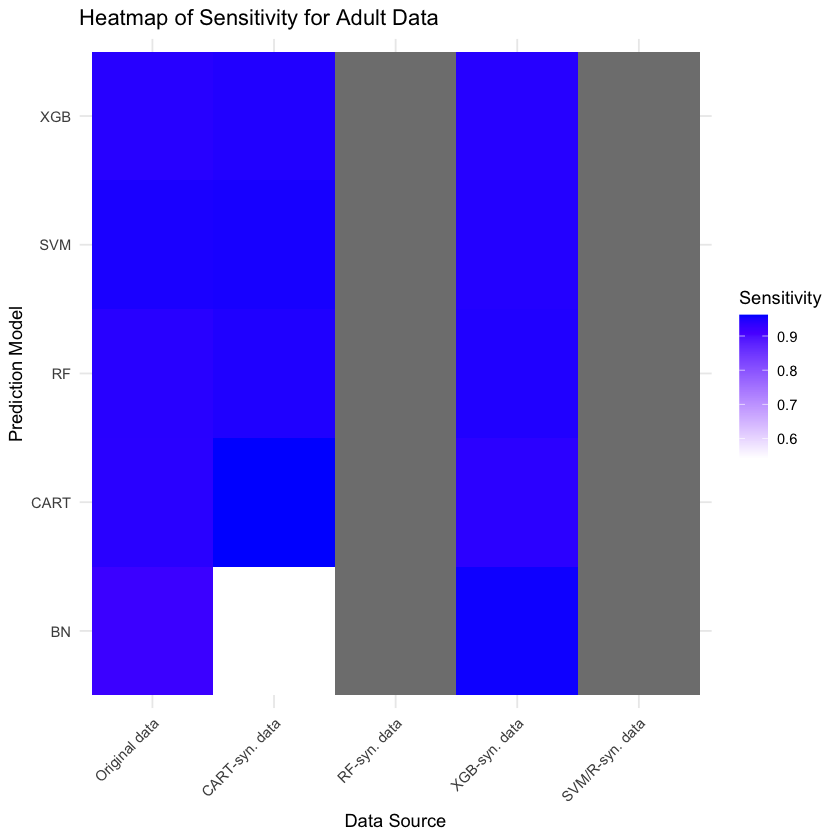

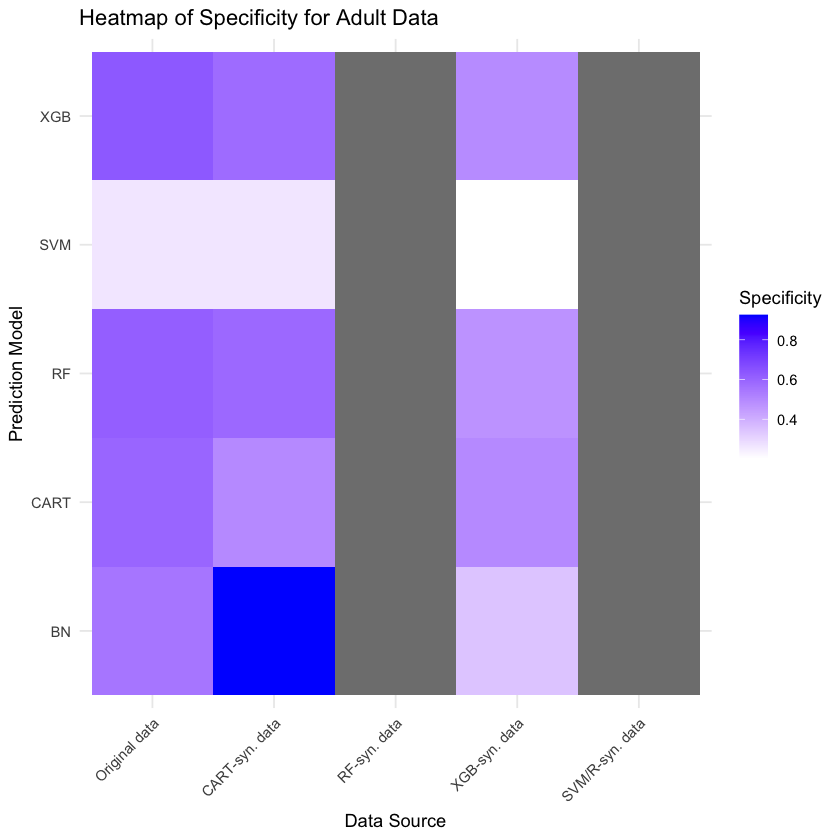

In [41]:
# Adult Data for heatmaps
adult_heatmap_data <- adult_table

# Iterate over each metric in the adult data
for (metric in metrics_classification) {
  # Filter the table for the current metric
  metric_data <- adult_heatmap_data[adult_heatmap_data$Metric == metric, ]
  
  # Melt the data into long format for ggplot
  metric_data_melt <- melt(metric_data, id.vars = c("Prediction Model", "Metric"))
  
  # Create the heatmap
  p <- ggplot(metric_data_melt, aes(x = variable, y = `Prediction Model`, fill = as.numeric(value))) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "blue", name = metric) +  # Set the name to the metric
    labs(title = paste("Heatmap of", metric, "for Adult Data"), x = "Data Source", y = "Prediction Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for better readability
  
  # Print the heatmap
  print(p)
}
